# Tutorial: Network-Based Time Series Analysis via Visibility Graphs

The objective of this tutorial is to introduce the network-based method of visbility graphs for nonlinear time series analysis and explain and illustrate their application with the __pyunicorn__ package. First some theoretical background for understanding visibility graphs will be given and then some methods provided by `pyunicorn.timeseries.VisibilityGraph` illustrated. For a detailed discussion and further references, please consult __[Donges et al., 2015](https://aip.scitation.org/doi/10.1063/1.4934554)__, on which this tutorial is based. 

## Introduction

_Visibility Graphs (VG)_ encode visibility relations between data points in the one-dimensional time domain, by drawing upon analogies between height profiles in physical space and the profile of a time series graph. VGs are based on the existence or non-existence of lines of sight between well-defined objects \[__[Donges et al., 2015](https://aip.scitation.org/doi/10.1063/1.4934554)__\].

They can be applied to investigate purely temporal features such as long-range correlations \[__[Lacasa et al., 2009](https://iopscience.iop.org/article/10.1209/0295-5075/86/30001)__\] or time reversal asymmetry \[__[Donges et al., 2013](https://iopscience.iop.org/article/10.1209/0295-5075/102/10004)__\].

## Theory of Time Series Visibility Graphs

### Standard Visibility Graph

In a time series context, well-defined objects between which lines of sight can be established are the sampling points of a (univariate) time series graph. These sampling points are uniquely characterised by pairs $(t_v, x_v)$ with $x_v = x(t_v)$. From a practical perspective, we can identify each node $v$ of a standard visibility graph with a given time point $t_v$. For $t_v < t_p$ (and, hence, $v < p$) a link between the nodes $v$ and $p$ exists iff

$$x_q < x_v + \frac{x_p-x_v}{t_p-t_v}(t_q - t_v)\;\forall\; v < q < p$$

Put differently, the topological properties of VGs take into account the time-ordering of observations explicitly and are thus closely related to the roughness of the underlying time series profile. An illustration of a timeseries with respective visibility relations (grey lines) can be seen in the figure below, taken from __[Donner and Donges, 2012](https://link.springer.com/article/10.2478/s11600-012-0032-x)__, that illustrates a timeseries . The VG of a time series stays invariant under arbitrary affine transformations.


![visibilitygraph](images/SimpleVG.PNG)

### Horizontal Visibility Graph

A notable algorithmic variant are _horizontal visibility graphs (HVGs)_ that facilitate analytical investigations of graph profiles \[__[Luque et al., 2009](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.046103)__\]. For HVGs the more restrictive condition

$$x_q<\text{min}\{x_v,x_p\}\;\forall\;v<q<p$$

holds and the linkset of a HVG is a subset of that of a standard VG. A HVG remains invariant only for uniform translations and rescaling of the original data. 

An illustrative example of a HVG can be seen in the figure below, taken from __[Luque et al., 2009](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.046103)__. In the upper part a time series is plotted with the respective horizontal visibility relations (arrowed lines) and in the lower part the resulting mapping to a HVG can be seen. 

![horizontalvisibilitygraph](images/HVG.PNG)

### Testing Time Series Irreversibility

By decomposing degrees and local clustering coefficients for VGs and HVGs into contributions from past and future observations, statistical properties under time-reversal of time series can be analysed, finding statistically significant deviations between the distributions of time-directed vertex properties for non-linear systems, that are known to be non-time-reversable, but not for linear systems \[__[Donges et al., 2013](https://iopscience.iop.org/article/10.1209/0295-5075/102/10004)__\].  

#### Time-Directed Vertex Properties \[__[Donges et al., 2013](https://iopscience.iop.org/article/10.1209/0295-5075/102/10004)__\]

To account for the fact that the time-ordering of data is intrinsically interwoven with the resulting network structure of VGs and HVGs, a set of statistical network quantifiers can be defined, based on two simple vertex (node) characteristics:

- Decomposing the degree $k_v$ of a vertex $v$, i.e. the number of edges incident to it, into contributions due to other vertices in the past and future of $t_v$, one obtains the time directed degree: $$k_v^r = \sum_{p\in V:p<v}A_{vp}$$ and $$k_v^a = \sum_{p\in V:p>v}A_{vp}\text{,}$$ with $k_v^r$ and $k_v^a$ being the time-retarded and the time-advanced degree respectively.


- In a similar manner, the local clustering coefficient $C_v$, which characterises the likelihood that the neighbours of $v$ are also connected, also can be expressed in terms of past and future contributions: $$C_v^r = \left( _{2}^{k_v^r} \right)^{-1} \sum_{p,q\in V:p,q<v}A_{vp}A_{pq}A_{qv}$$ and $$C_v^a = \left( _{2}^{k_v^a} \right)^{-1} \sum_{p,q\in V:p,q>v}A_{vp}A_{pq}A_{qv}\text{,}$$ with $C_v^r$ and $C_v^a$ being the time-retarded and the time-advanced local clustering coefficient.

#### Irreversibility-Test via Kolmogorov-Smirnov (KS) 

Looking at the frequency distributions $p(k_v^r)$, $p(k_v^a)$, $p(C_v^r)$ and $p(C_v^a)$, it is expected that the retarded and advanced sequences for one vertex characteristic, e.g. $\{k_v^r\}$ and $\{k_v^a\}$ should be drawn from the same probability distributions, $p(k_v^r)$ and $p(k_v^a)$, in case of time reversibility. Then, rejecting the null hypothesis that  $\{k_v^r\}$ and $\{k_v^a\}$ ($\{C_v^r\}$ and $\{C_v^a\}$) are drawn from the same probability distribution, respectively, is equivalent to rejecting the null hypothesis that the TS is reversible. For sufficiently long time series the samples of individual vertex properties approximate the underlying distributions sufficiently well and the Kolmogorov-Smirnov (KS) test can be used to check this hypothesis. Specifically, a small $p$-value of the KS test static (e.g., $p<0.05$) implies that the time series has likely been generated by an irreversible process.

For illustration purposes, the distributions of time-directed vertex properties of a linear and a non-linear timeseries will be analysed in the following section and evaluated.

## Application of Visibility Graphs

As an example for the application of VGs and HVGs and the class `VisibilityGraph` a linear and a non-linear time series are visually tested and the KS test is applied for irreversibility with the distributions of time-directed vertex properties, after going through some basic concepts.

### First Steps

Import all needed packages.

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from pyunicorn.timeseries import VisibilityGraph

Then we create and plot linear a time series (TS) based on a linear-stochastic first-order autoregressive (AR(1)) with an additive gaußian noise term $\xi$:
$$x_t = \alpha x_{t-1} + \xi_t \text{,}$$ 
where $\alpha = 0.5$ 
For more background on the construction of time series, consult __[Shumway and Stoffer, 2017](https://link.springer.com/book/10.1007/978-3-319-52452-8)__. 

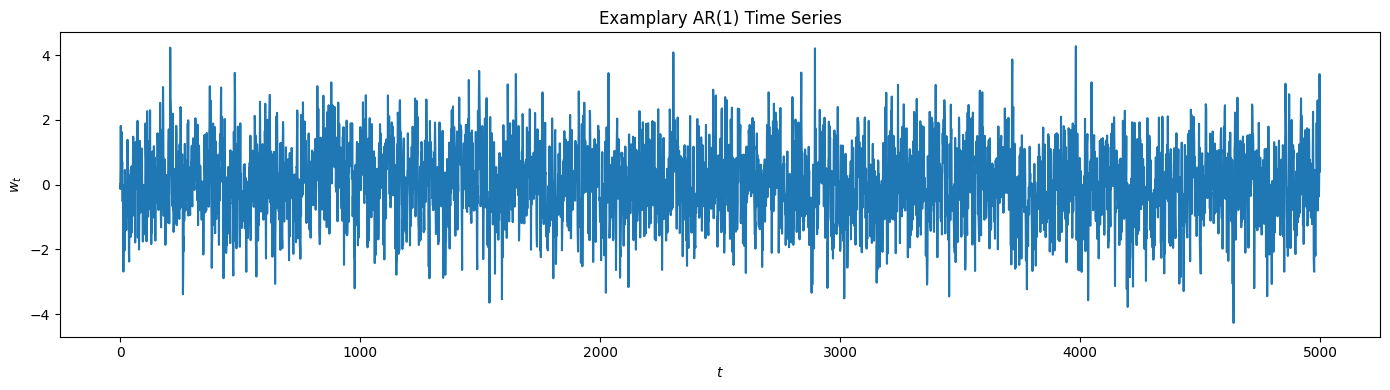

In [7]:
np.random.seed(42) # we set a seed to reproduce results later
mu, sigma = 0, 1 # mean and standard deviation
N = 5000
xi = np.random.normal(mu, sigma, N) # gaussian noise time series
a = 0.5
w_t = [0]
t = np.arange(0, N, 1) # construct time array
for i in t[1:]:
    w_t.append(a*w_t[i-1]+xi[i])
w_t = np.asarray(w_t)
    
# plot the timeseries
fig = plt.figure(figsize=(14, 4))
ax = plt.plot(t, w_t)
ax = plt.xlabel("$t$")
ax = plt.ylabel("$w_t$")
ax = plt.title("Examplary AR(1) Time Series")
fig.tight_layout()
plt.show()

Now we construct an object of class VisibilityGraph. Note the keyword `horizontal`, that can be set to be `False` or `True`, and is `False` by default. We denote the object with "1" to distinguish it from the second timeseries that will be analysed later on.

In [5]:
VG1 = VisibilityGraph(w_t, horizontal = False) # creating object
print(VG1)

Calculating visibility relations...
VisibilityGraph: time series shape (5000,).
InteractingNetworks:
Network: undirected, 5000 nodes, 16703 links, link density 0.001.


In [6]:
HVG1 = VisibilityGraph(w_t, horizontal = True)
print(HVG1)

Calculating horizontal visibility relations...
VisibilityGraph: time series shape (5000,).
InteractingNetworks:
Network: undirected, 5000 nodes, 9986 links, link density 0.001.


It can be illustrative to plot the visibility relations for the VG for better understanding of the concept. They can be obtained with the method `VisibilityGraph.visibility_relations()`. Note that we zoom in a bit here, by only plotting the first 200 data points.

Calculating visibility relations...


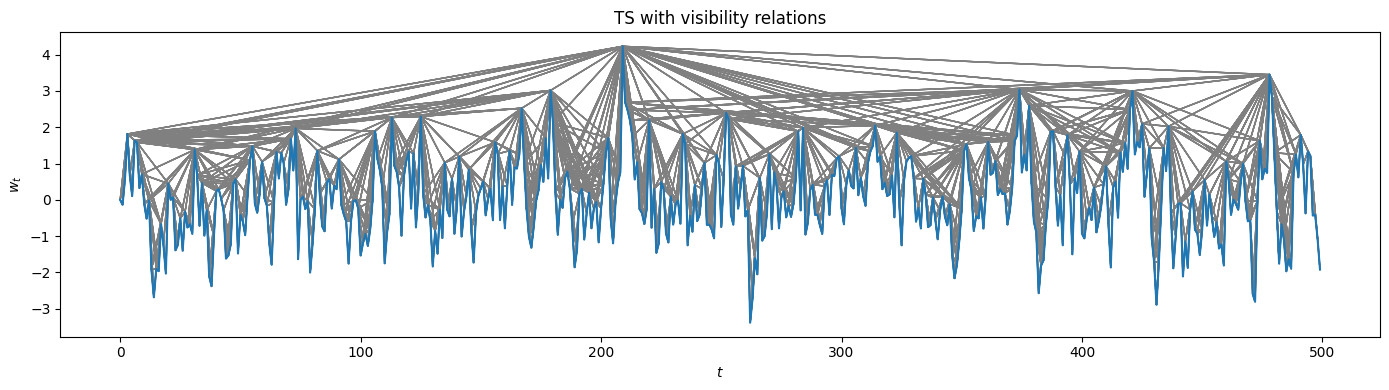

In [8]:
# obtain the visibilty relations as an narray with boolean values
# i.e. Trure: two data points are "visible" to each other
visibility_relations = VG1.visibility_relations()
cutoff = int(N/10)
fig = plt.figure(figsize=(14, 4))
ax = plt.plot(t[:cutoff], w_t[:cutoff]) # zooming in a bit
ax = plt.xlabel("$t$")
ax = plt.ylabel("$w_t$")
ax = plt.title("TS with visibility relations")
fig.tight_layout()
# plotting the visibilty relations as grey arrows
for i in range(cutoff):
    for k in range(cutoff):
        if visibility_relations[i][k]:
            ax = plt.arrow(i, w_t[i], (k-i), (w_t[k]-w_t[i]), color='grey')
plt.show()

Of course, we can also plot the visibility relations for the HVG after obtaining them with `VisibilityGraph.visibility_relations_horizontal()`. In this case only the relations for one specific node are plotted as an example, so that one can easily convince themselves that there is only a link between data points for which a horizontal line could be drawn. (Note though that the visibility lines are not plotted in a horizontal manner here). 

Calculating horizontal visibility relations...


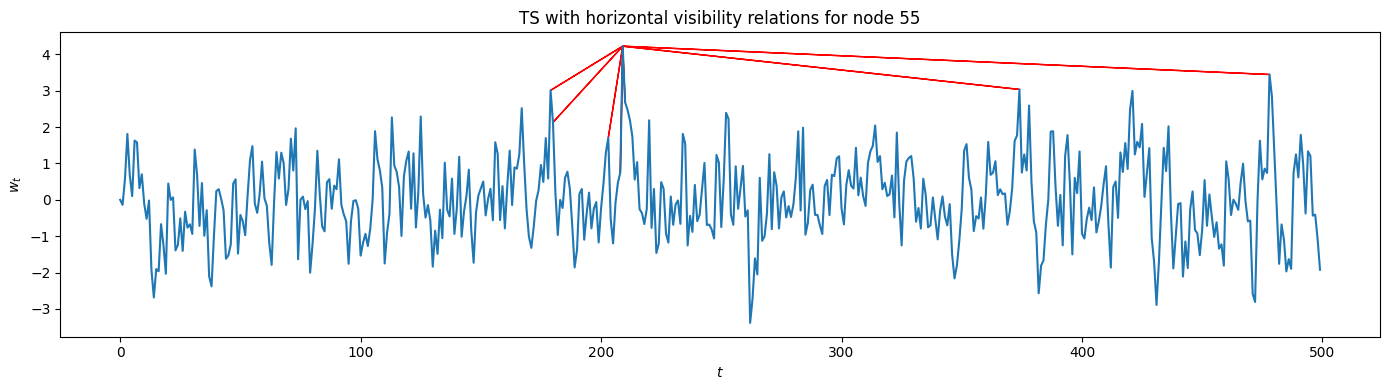

In [9]:
visibility_relations_horizontal = HVG1.visibility_relations_horizontal()
cutoff = int(N/10)
fig = plt.figure(figsize=(14, 4))
ax = plt.plot(t[:cutoff], w_t[:cutoff]) # zooming in a bit
ax = plt.xlabel("$t$")
ax = plt.ylabel("$w_t$")
ax = plt.title("TS with horizontal visibility relations for node 55")
fig.tight_layout()

i = 209 # only plot the nodes visible to node 209
for k in range(cutoff):
    if visibility_relations_horizontal[i][k]:
        ax = plt.arrow(i, w_t[i], (k-i), (w_t[k]-w_t[i]), color='red')

plt.show()

### Irreversibility Test

#### Linear Time Series

We start by analysing the linear time series on irreversibility. For this we use the time directed degrees via:
- `VisibilityGraph.retarded_degree()`
- `VisibilityGraph.advanced_degree()`

In [10]:
k_r1 = VG1.retarded_degree() # obtain retarded degree
k_a1 = VG1.advanced_degree() # obtain advanced degee

Applied to VG both methods return an array with the corresponding degree for each node. For such an array we can obtain the probability for each degree with a kernel-density estimate using Gaussian kernels. [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) is a way to estimate the probability density function (PDF) of a random variable in a non-parametric way. We use `scipy.stats.gaussian_kde` for that.

In [11]:
from scipy.stats import gaussian_kde 
gkde_r1 = gaussian_kde(k_r1)
gkde_a1 = gaussian_kde(k_a1)

Now we plot $p(k_v^r)$ against $k_v^r$ in red and $p(k_v^a)$ against $k_v^a$ in black and compare both visiually. The first figure is plotted on a non-logartihmic y-scale and the second one on a logartihmic scale. Both plots are cutoff at a degree of 12, for which probabilities get very low too be comparable. 

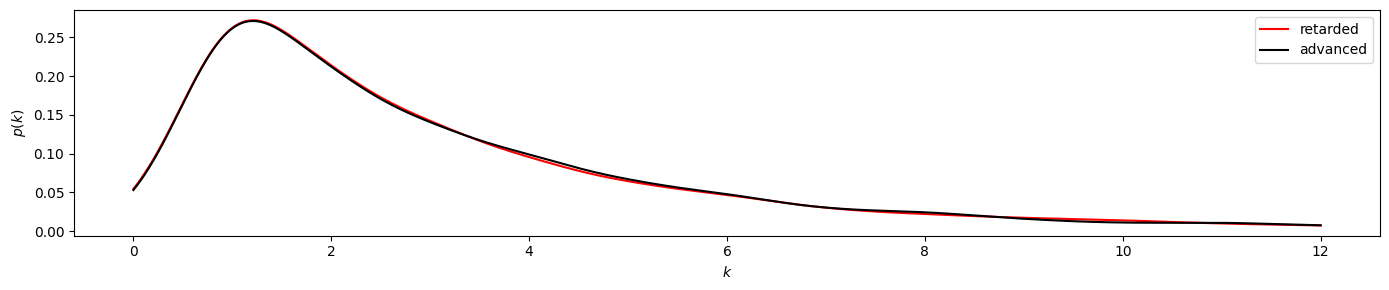

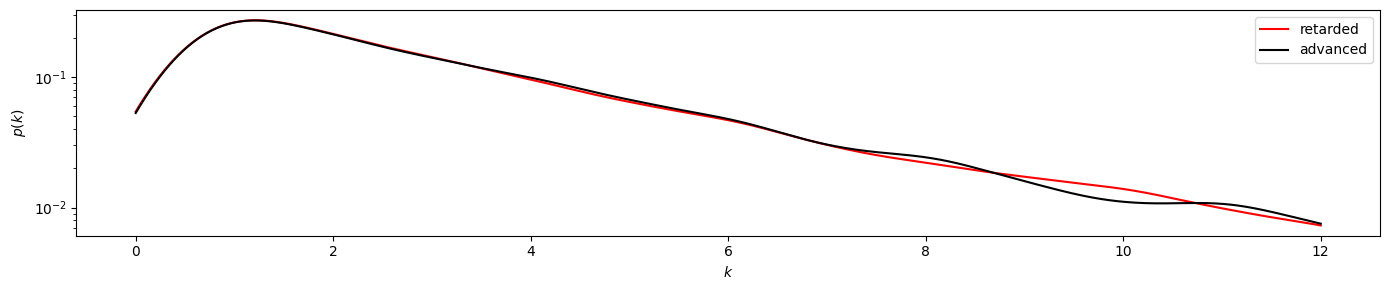

In [12]:
fig = plt.figure(figsize=(14, 3))
x = np.linspace(0, 12, 1000)
ax = plt.plot(x, gkde_r1.evaluate(x), color="red", label="retarded")
ax = plt.plot(x, gkde_a1.evaluate(x), color="black", label="advanced")
ax = plt.xlabel("$k$")
ax = plt.ylabel("$p(k)$")
ax = plt.legend()
fig.tight_layout()

fig = plt.figure(figsize=(14, 3))
x = np.linspace(0, 12, 1000)
ax = plt.plot(x, gkde_r1.evaluate(x), color="red", label="retarded")
ax = plt.plot(x, gkde_a1.evaluate(x), color="black", label="advanced")
ax = plt.xlabel("$k$")
ax = plt.ylabel("$p(k)$")
ax = plt.legend()
ax = plt.yscale("log")
fig.tight_layout()

By visual investigation we already find strong similarities in the distributions. Now we also apply the KS test for this time series. For this we can use `scipy.stats.ks_2samp`, which gives us the $p$-value of two input data sets, therefore telling us if they are likely to have been drwawn from the same distribution, which would be the case for an reversible process. E.g. $p>0.05$ would imply then that the time series has likely been generated by an reversible process.

In [13]:
from scipy.stats import ks_2samp
ks_2samp(k_r1, k_a1)

KstestResult(statistic=0.0072, pvalue=0.9994903068538411, statistic_location=3.0, statistic_sign=1)

The result of `pvalue=0.999... > 0.050` implies reversibility of the time series.

#### Non-Linear Time Series

Now we do the same for a non-linear time series. We can construct one using the logistic map for instance, which we take from the tutorial for the recurrence plots. We only change the bifurcation parameter to find ourselves deeply in the chaotic regime to $r = 4$.

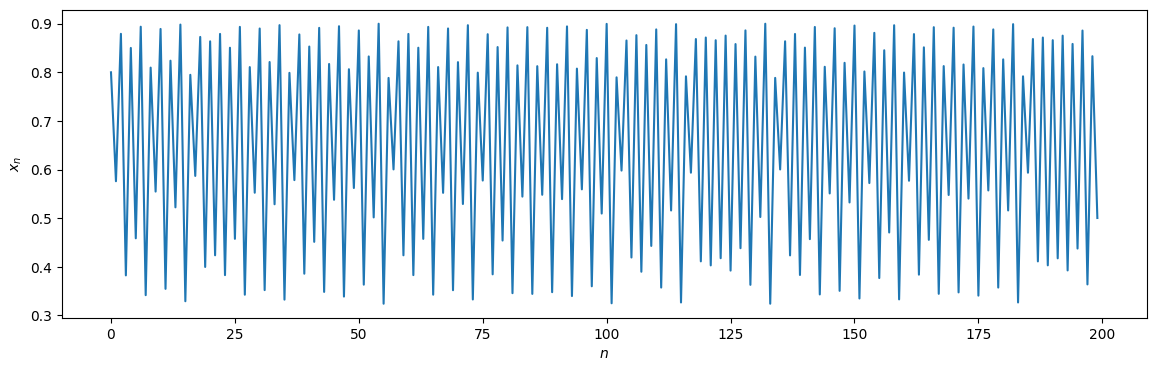

In [15]:
def logistic_map(x0, r, T):
    """
    Returns a time series of length T using the logistic map,
    x_(n+1) = r*x_n(1-x_n) at parameter r and using the initial condition x0.
    INPUT: x0 - Initial condition, 0 <= x0 <= 1
            r - Bifurcation parameter, 0 <= r <= 4
            T - length of the desired time series
    """
    #  Initialize the time series array
    timeSeries = np.empty(T)

    timeSeries[0] = x0
    for i in range(1, len(timeSeries)):
        xn = timeSeries[i-1]
        timeSeries[i] = r * xn * (1 - xn)

    return timeSeries

r = 3.6
x0 = 0.8
T = 5000

time_series = logistic_map(x0, r, T)
fig = plt.figure(figsize=(14, 4))
ax = plt.plot(time_series[:200]) # also zooming in a bit here
ax = plt.xlabel("$n$")
ax = plt.ylabel("$x_n$")

We apply the same procedure as before for the linear TS.

Calculating visibility relations...


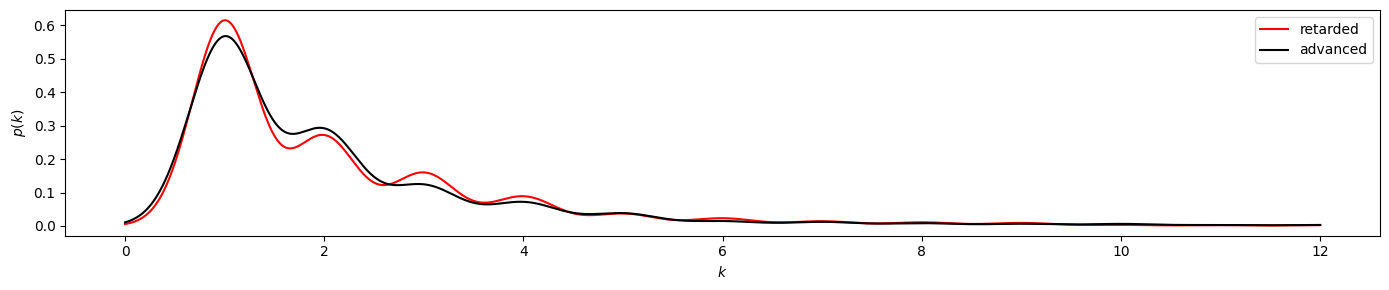

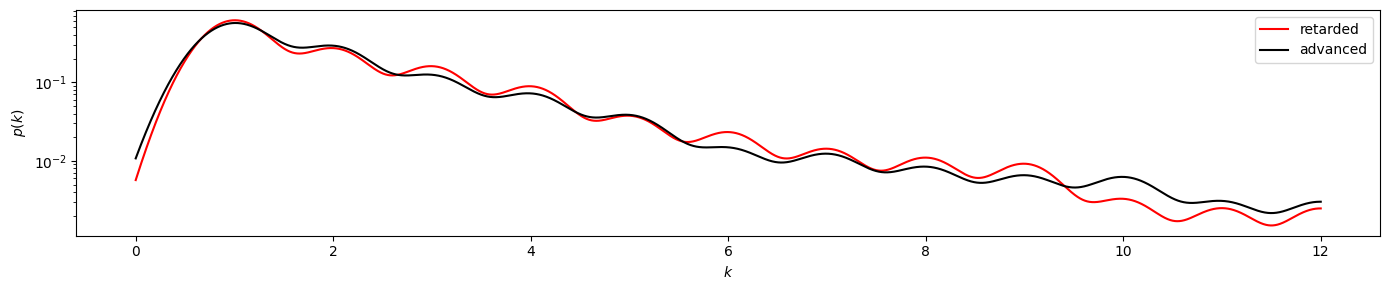

In [16]:
VG2 = VisibilityGraph(time_series)
k_r2 = VG2.retarded_degree()
k_a2 = VG2.advanced_degree()
gkde_r2 = gaussian_kde(k_r2)
gkde_a2 = gaussian_kde(k_a2)

fig = plt.figure(figsize=(14, 3))
x = np.linspace(0, 12, 5000)
ax = plt.plot(x, gkde_r2.evaluate(x), color="red", label="retarded")
ax = plt.plot(x, gkde_a2.evaluate(x), color="black", label="advanced")
ax = plt.xlabel("$k$")
ax = plt.ylabel("$p(k)$")
ax = plt.legend()
fig.tight_layout()

fig = plt.figure(figsize=(14, 3))
x = np.linspace(0, 12, 5000)
ax = plt.plot(x, gkde_r2.evaluate(x), color="red", label="retarded")
ax = plt.plot(x, gkde_a2.evaluate(x), color="black", label="advanced")
ax = plt.xlabel("$k$")
ax = plt.ylabel("$p(k)$")
ax = plt.legend()
ax = plt.yscale("log")
fig.tight_layout()

Here we already visually find a stronger divergence between retarded and advanced degree distribution, suggesting non-linearity of the underlying time series.

We appply the KS test again.

In [17]:
ks_2samp(k_r2, k_a2)

KstestResult(statistic=0.032, pvalue=0.011947718089521279, statistic_location=2.0, statistic_sign=-1)

The result `pvalue < 0.050` suggests that the TS is time-irreversible.